In [1]:
import pandas as pd
from tensorflow.keras.saving import load_model
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

## Some parameters

In [9]:
test_day = 0  # must be an element in [0, 1, 2, 3, 4, 5]
ticker = "ADSK"

## Helper functions copied from src/models/lstm.py

In [2]:
def get_dates_for_training_scheme(df: pd.DataFrame):
    """
    This function returns all dates needed to train, validate and test the model. The training
    follows a rolling window type scheme. The data is trained on 4 days and validated on the 5th. 
    Some portion of the end of the dates are used for testing.

    Args:
        df (pd.DataFrame): dataframe with data.

    Returns:
        List[Tuples]: a list of tuples conatining the training and validation/test dates.
    """
    dates = df["sip_timestamp"].dt.day.unique()

    date_set = []

    num_days_training = 9
    num_days_val_test = 1

    for i in range(0, len(dates) - num_days_training, num_days_val_test):
        date_set.append((dates[i: i + num_days_training], dates[i + num_days_training: i + num_days_training + num_days_val_test]))

    return date_set

def train_val_test(df: pd.DataFrame, days: tuple[np.ndarray, np.ndarray]):
    """
    Splits a dataframe into training and val/test. The splitting is done by given dates.

    Args:
        df (pd.DataFrame): dataframe to split into training and test.
        days (tuple[np.ndarray, np.ndarray]): a tuple containing two arrays of train days and val/test days respectively

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: a train and val/test set of the original dataframe
    """
    
    train = df[df["sip_timestamp"].dt.day.isin(days[0])]
    val_test = df[df["sip_timestamp"].dt.day.isin(days[1])]

    return train, val_test

def create_sequences(data: np.ndarray, seq_length: int):
    """
    Convert DataFrame into sequences of specified length for LSTM input.

    Args: 
        data (np.array): complete data containing both x and y
        seq_length (int): the length of the sequence considered in the lstm.

    Returns:
        (np.array, np.array): x and y datasets with the sequences. 
    """
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, :])  # all columns, including the last one, as features
        y.append(data[i + seq_length, -1])  # last column's lagged value as target

    return np.array(x), np.array(y)

def create_sequences_modified(data, seq_length):
    """
    Convert DataFrame into sequences of specified length for LSTM input. Makes sure sequences do not 
    contain data from different dates.

    Args: 
        data (np.array): complete data containing both x and y
        seq_length (int): the length of the sequence considered in the lstm.

    Returns:
        (np.array, np.array): x and y datasets with the sequences. 
    """
    X, y = [], []
    for date, group_data in data.groupby("date"):
        group_data = group_data.drop(columns=["date"]).values
        X_date, y_date = create_sequences(group_data, seq_length)
        X.append(X_date)
        y.append(y_date)
    return np.concatenate(X), np.concatenate(y)

In [3]:
def get_best_config(ticker: str):
    config_loss_df = pd.read_csv("../../reports/config_space_loss.csv")
    config_loss_df = config_loss_df[config_loss_df["ticker"] == ticker]
    
    id_min_loss = config_loss_df["mse"].idxmin()
    config = config_loss_df.loc[id_min_loss,:]
    config = config.drop(index = ["ticker", "mse"])
    config = config.to_dict()
    return config

## Loading data and creating model

In [36]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")

In [10]:
ticker_data = df[df["ticker"] == ticker].copy()
ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

In [11]:
config = get_best_config(ticker)
# config = {'seq_length': 60, 'n_layers': 3, 'units': 16, 'n_features': 1.0, 'l2_reg': 0.0}

date_scheme = get_dates_for_training_scheme(ticker_data)

num_days_testing = 6
date_scheme_test = date_scheme[-num_days_testing:]
date_set = date_scheme_test[test_day]

train, test = train_val_test(ticker_data, date_set)

scaler = StandardScaler()

ts = test["sip_timestamp"].iloc[config["seq_length"]:]

train = train.drop(columns=["ticker", "sip_timestamp"])
test = test.drop(columns=["ticker", "sip_timestamp"])

scaler = StandardScaler()

columns_to_standardize = train.columns[:-1] # standardize all columns except date

for col in columns_to_standardize:
    scaler.fit(train.loc[train[col] != 0, [col]])
    train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
    test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

# train.loc[:, train.columns != "date"] = scaler.fit_transform(train.loc[:, train.columns != "date"])
# test.loc[:, test.columns != "date"] = scaler.transform(test.loc[:, test.columns != "date"])

X_train, y_train = create_sequences_modified(train, config["seq_length"])
X_test, y_test = create_sequences_modified(test, config["seq_length"])

model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

y_pred = model.predict(X_test).flatten()

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [12]:
config

{'seq_length': 12,
 'n_layers': 3.0,
 'units': 12.0,
 'l2_reg': 0.0652471656694728,
 'lr': 0.0130134689488177,
 'n_features': 6.0}

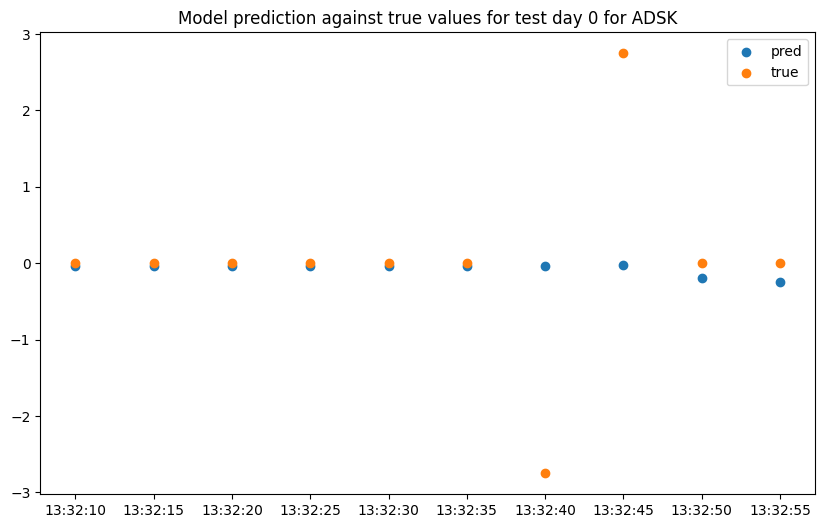

In [13]:
subset = slice(10, 20)

plt.figure(figsize=(10, 6))
plt.scatter(ts.iloc[subset], y_pred[subset], label="pred")
plt.scatter(ts.iloc[subset], y_test[subset], label="true")
plt.legend()
plt.title(f"Model prediction against true values for test day {test_day} for {ticker}")
plt.show()

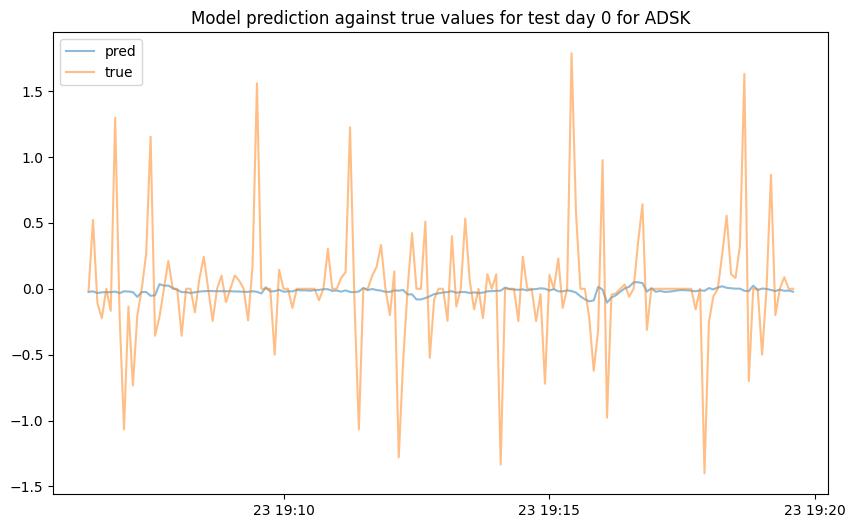

In [18]:
mn = 4020
mx = 4180

plt.figure(figsize=(10, 6))
plt.plot(ts.iloc[mn:mx], y_pred[mn:mx], label="pred", alpha=0.5)
plt.plot(ts.iloc[mn:mx], y_test[mn:mx], label="true", alpha=0.5)
plt.legend()
plt.title(f"Model prediction against true values for test day {test_day} for {ticker}")
plt.show()

In [58]:
model_loss = np.mean((y_test-y_pred)**2)
martingale_loss = np.mean((y_test-0)**2)

print(f"Model loss {model_loss}")
print(f"Martingale loss {martingale_loss}")

if model_loss <= martingale_loss:
    print("Model better")
else:
    print("Martingale better")

Model loss 0.04016758223096554
Martingale loss 0.04002045428354976
Martingale better


### What models beat the benchmark

In [4]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")

In [9]:
tot_loss_dic = {}

for ticker in df["ticker"].unique():
    print(f"{ticker}")
    # if ticker != "AMED": continue
    tot_loss_dic[ticker] = {"test_day": [], "model_loss": [], "martingale_loss": [], "model_best": []}

    ticker_data = df[df["ticker"] == ticker].copy()
    ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
    ticker_data["date"] = ticker_data["sip_timestamp"].dt.date
    try:
        config = get_best_config(ticker)
    except:
        continue

    date_scheme = get_dates_for_training_scheme(ticker_data)

    num_days_testing = 6
    date_scheme_test = date_scheme[-num_days_testing:]

    
    for test_day in range(6):
        date_set = date_scheme_test[test_day]

        train, test = train_val_test(ticker_data, date_set)

        scaler = StandardScaler()

        train = train.drop(columns=["ticker", "sip_timestamp"])
        test = test.drop(columns=["ticker", "sip_timestamp"])

        scaler = StandardScaler()

        columns_to_standardize = train.columns[:-1] # standardize all columns except date

        for col in columns_to_standardize:
            scaler.fit(train.loc[train[col] != 0, [col]])
            train.loc[train[col] != 0, col] = scaler.transform(train.loc[train[col] != 0, [col]])
            test.loc[test[col] != 0, col] = scaler.transform(test.loc[test[col] != 0, [col]])

        X_train, y_train = create_sequences_modified(train, config["seq_length"])
        X_test, y_test = create_sequences_modified(test, config["seq_length"])

        model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

        y_pred = model.predict(X_test, verbose=False).flatten()

        model_loss = np.mean((y_test-y_pred)**2)
        martingale_loss = np.mean((y_test-0)**2)

        tot_loss_dic[ticker]["test_day"].append(test_day)
        tot_loss_dic[ticker]["model_loss"].append(model_loss)
        tot_loss_dic[ticker]["martingale_loss"].append(martingale_loss)
        tot_loss_dic[ticker]["model_best"].append(1 if model_loss <= martingale_loss else 0)


ADSK
AEP
AHH
ALEC
AMED
APYX
ARTNA
ARVN
BANF
BELFB
BKD
BTU
BV
CB
CFBK
CHE
CIVB
CLDX
CNA
COHU
CRBP
CRMD
CRMT
CWT
DOMO
DVAX
EAF
EPM
ESRT
EVTC
FDS
FGBI
FITB
FULT
FWONA
GCI
GDDY
GNE
HAL
HFBL
HLF
HTBI
IBCP
ICAD
IPG
JELD
KEY
LYTS
MARA
MEDP
MESA
MMM
NDAQ
NGVT
NNI
NVEC
NX
NYT
OPI
OXM
PATK
PFS
PHX
PODD
POR
POWL
PPBI
QRVO
RCM
ROCK
RRGB
SABR
SACH
SEM
SLP
TER
TIPT
TPIC
TTWO
TXN
UNP
USFD
USPH
V
VNDA
VSH
WAB
WBA
WGO
WHG
WKHS
WLK
WWD
XELB
XTNT


In [10]:
df_list = []
for ticker, data in tot_loss_dic.items():
    temp_df = pd.DataFrame(data) 
    temp_df['ticker'] = ticker    
    df_list.append(temp_df)

result_df = pd.concat(df_list, ignore_index=True)

result_df

,test_day,model_loss,martingale_loss,model_best,ticker
0,0.0,0.348235,0.350099,1.0,ADSK
1,1.0,0.310167,0.310779,1.0,ADSK
2,2.0,0.328111,0.327487,0.0,ADSK
3,3.0,0.282636,0.285528,1.0,ADSK
4,4.0,0.361966,0.363682,1.0,ADSK
...,...,...,...,...,...
265,1.0,0.209940,0.207672,0.0,JELD
266,2.0,0.198075,0.197375,0.0,JELD
267,3.0,0.279967,0.278788,0.0,JELD
268,4.0,0.299285,0.298704,0.0,JELD


In [11]:
result_df.model_best.mean()

0.28888888888888886

In [12]:
result_df.groupby(by="test_day")["model_best"].mean()

test_day
0.0    0.400000
1.0    0.266667
2.0    0.222222
3.0    0.266667
4.0    0.244444
5.0    0.333333
Name: model_best, dtype: float64